In [1]:
""" Generalized Additive Models for Trend and Seasonality analysis of Time Series data"""
import pandas as pd 
import numpy as np 
import sqlite3 as sql 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import Manager, get_path 
from models.anom.stocks.connect import data
connections = get_path('../../../')
# J = Manager(connections)
d = data(connections)

Options db Connected: 2025-01-04 20:19:09.643587
Prices Connected: 2025-01-04 20:19:09.644257





## Generalized Additive Models, In General 


$$
y \sim \text{ExponentialFamily}(\mu|X\beta, \phi) \\
g(\mu) = X\beta \\
\text{where} \\
\mu = \text{E}(y) \\
\text{Var}(y) = \phi V(\mu) \\
\text{and} \\
V(\mu) = \text{Var}(y) \\
\text{and} \\
\phi = \text{Dispersion Parameter}
$$

In [2]:
X, y = d._returnxy('qcom')
X, y = X.values[:-1], y.values[:-1]
print(X.shape, y.shape)
list(enumerate(d.feature_names))[:15]

(770, 34) (770,)


[(0, 'call_vol'),
 (1, 'put_vol'),
 (2, 'call_oi'),
 (3, 'put_oi'),
 (4, 'call_prem'),
 (5, 'put_prem'),
 (6, 'call_iv'),
 (7, 'put_iv'),
 (8, 'atm_iv'),
 (9, 'otm_iv'),
 (10, 'put_spread'),
 (11, 'call_spread'),
 (12, 'put_gamma'),
 (13, 'call_gamma'),
 (14, 'call_delta')]

## Plotting a 3d surface 

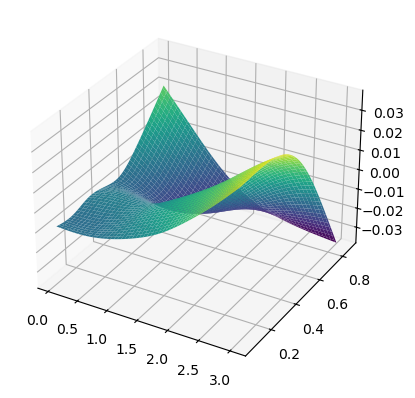

In [3]:
from pygam import GAM, s, f, l, te, PoissonGAM, LogisticGAM, LinearGAM
# model = GAM(s(0, n_splines=200) + te(3,1) + s(2), distribution='poisson', link='log').fit(X, y)
gam = LinearGAM(s(0, n_splines=200) + te(6, 7) + s(2)).fit(X, y)

# XX = model.generate_X_grid(term=1, meshgrid=True)
# Z = model.partial_dependence(term=1, X=XX, meshgrid=True)
XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


(748, 1) (748,)


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0.5, 1.0, 'draw samples from the posterior of the coefficients')

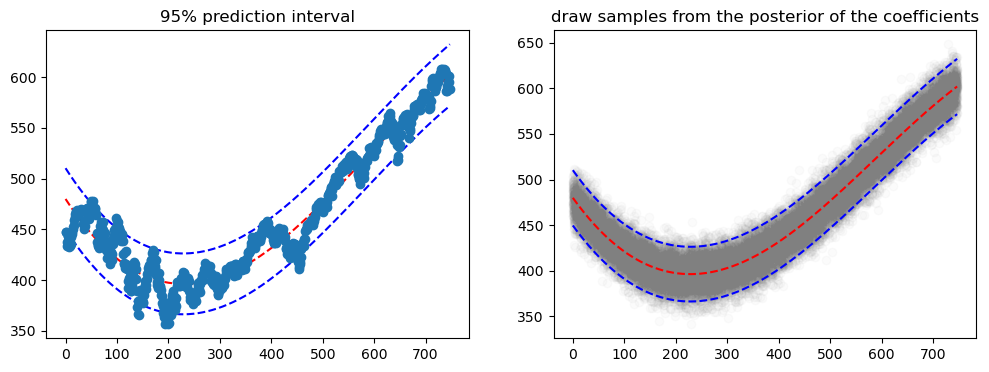

In [4]:
X, y = d._returnxy('spy', keep_close = True)
X, y = X.values[:-1, 6:7], y.values[:-1]
# add timesteps 
# X = np.c_[np.arange(X.shape[0]), X].reshape(-1, 2)
X = np.arange(X.shape[0]).reshape(-1, 1)
print(X.shape, y.shape)


gam = LinearGAM(n_splines=5).gridsearch(X, y)
XX = gam.generate_X_grid(term=0, n=500)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(XX, gam.predict(XX), 'r--')
ax[0].plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
ax[0].plot(X, y, 'o')
ax[0].set_title('95% prediction interval');

# continuing last example with the mcycle dataset
for response in gam.sample(X, y, quantity='y', n_draws=50, sample_at_X=XX):
    ax[1].scatter(XX, response, alpha=.03, color='grey')
ax[1].plot(XX, gam.predict(XX), 'r--')
ax[1].plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
ax[1].set_title('draw samples from the posterior of the coefficients')

In [5]:
y.shape, XX.shape, X.shape

((748,), (500, 1), (748, 1))

## Expectiles: 

GAM with a normal distribution suffer from the limitation of an assumed constant variance, sometimes this is not an appropriate assumtpion because wed like the variance of our error distribution to vary. In this case we can resort to modeling the expectiles of a distribtuion. Expectiles are like Quantiles, but model the tail expectations instead of the tail mass. Although they are less interpretable, they are much faster to fit, and can also be used to non-parametrically model the variance of the error distribution.

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


(748, 1) (748,)


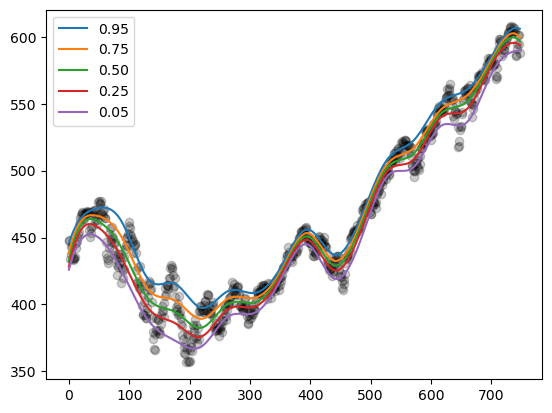

In [6]:
from pygam import ExpectileGAM
X, y = d._returnxy('spy', keep_close = True)
X, y = X.values[:-1, 6:7], y.values[:-1]
X = np.arange(X.shape[0]).reshape(-1, 1) # timesteps 
print(X.shape, y.shape)
# lets fit the mean model first by CV
gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y)

# and copy the smoothing to the other models
lam = gam50.lam

# now fit a few more models
gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X, y)
gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X, y)
gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X, y)
gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X, y)

XX = gam50.generate_X_grid(term=0, n=500)

plt.scatter(X, y, c='k', alpha=0.2)
plt.plot(XX, gam95.predict(XX), label='0.95')
plt.plot(XX, gam75.predict(XX), label='0.75')
plt.plot(XX, gam50.predict(XX), label='0.50')
plt.plot(XX, gam25.predict(XX), label='0.25')
plt.plot(XX, gam05.predict(XX), label='0.05')
plt.legend()

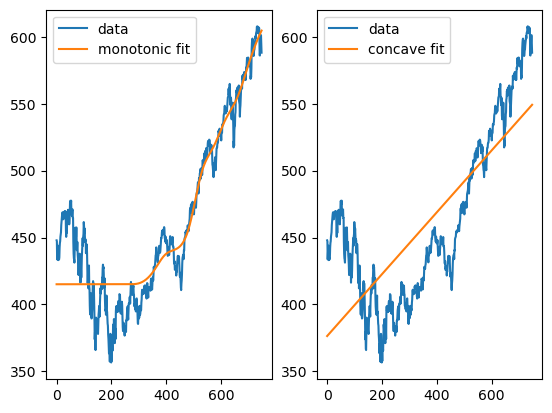

In [7]:
gam1 = LinearGAM(s(0, constraints='monotonic_inc')).fit(X, y)
gam2 = LinearGAM(s(0, constraints='concave')).fit(X, y)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, label='data')
ax[0].plot(X, gam1.predict(X), label='monotonic fit')
ax[0].legend()

ax[1].plot(X, y, label='data')
ax[1].plot(X, gam2.predict(X), label='concave fit')
ax[1].legend()

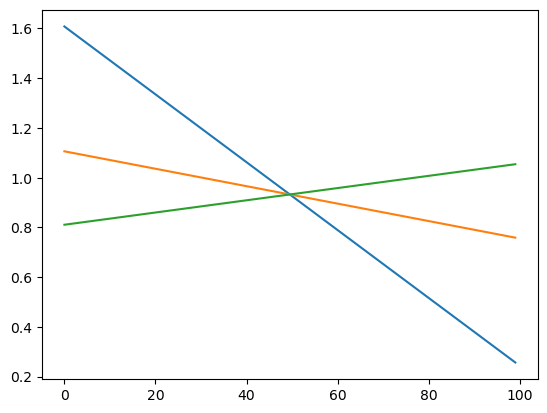

In [8]:
X, y = d._returnxy('spy', keep_close = True)
X, y = X.values[:-1, 6:9], y.values[:-1]
y = d.binary_convert(y, buy = 1, sell = 0 )
# X = np.concatenate([np.arange(X.shape[0]).reshape(-1, 1), X], axis=1)

gam = LogisticGAM(s(0) + s(1) + s(2)).fit(X, y)

plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


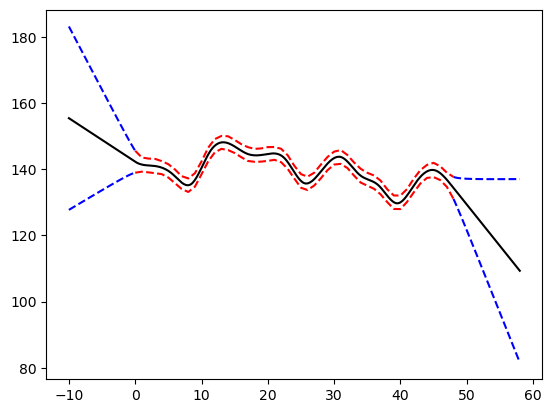

In [9]:
X, y = d._returnxy('nvda', keep_close = True)
X, y = X.values[-50:-1, 6], y.values[-50:-1]
X = np.arange(X.shape[0]).reshape(-1, 1) # timesteps 


gam = LinearGAM()
gam.gridsearch(X, y)

XX = gam.generate_X_grid(term=0)

m = X.min()
M = X.max()
XX = np.linspace(m - 10, M + 10, 500)
Xl = np.linspace(m - 10, m, 50)
Xr = np.linspace(M, M + 10, 50)

plt.figure()

plt.plot(XX, gam.predict(XX), 'k')
plt.plot(Xl, gam.confidence_intervals(Xl), color='b', ls='--')
plt.plot(Xr, gam.confidence_intervals(Xr), color='b', ls='--')
_ = plt.plot(X, gam.confidence_intervals(X), color='r', ls='--')

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


(686, 35) (686,)


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:35
 18% (2 of 11) |####                     | Elapsed Time: 0:00:05 ETA:   0:00:23
 27% (3 of 11) |######                  

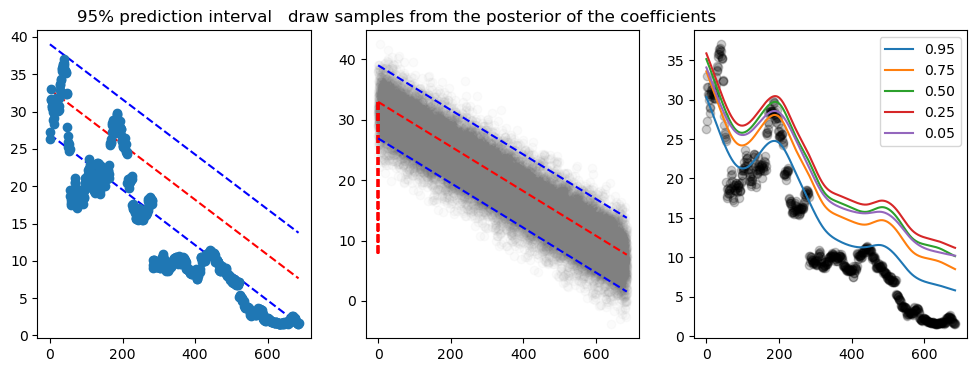

In [10]:
X, y = d._returnxy('spy', keep_close = True)
# X, y = X.values[:-1, 6:7], y.values[:-1]
X, y = X.values[:-1, :], y.values[:-1]
# add timesteps 
X = np.c_[np.arange(X.shape[0]), X]
# X = np.arange(X.shape[0]).reshape(-1, 1)
print(X.shape, y.shape)


t1 = [1,3,5,7,9]
t2 = [2,4,6,8,10]
term = [te(i, j) for i, j in zip(t1, t2)]
# gam= LinearGAM(l(0) + te(1, 2) + te(2,3)).gridsearch(X, y)
gam= LinearGAM(l(0) + te(6, 7)).gridsearch(X, y)
XX = gam.generate_X_grid(term=0, n=500)

# lets fit the mean model first by CV
gam50 = ExpectileGAM(expectile=0.5, fit_intercept=False).gridsearch(X, y)

# and copy the smoothing to the other models
lam = gam50.lam

# now fit a few more models
gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X, y)
gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X, y)
gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X, y)
gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X, y)

xx50 = gam50.generate_X_grid(term=0, n=500)


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(XX[:, 0], gam.predict(XX), 'r--')
ax[0].plot(XX[:, 0], gam.prediction_intervals(XX, width=.95), color='b', ls='--')
ax[0].plot(X[:, 0], y, 'o')
ax[0].set_title('95% prediction interval');

# continuing last example with the mcycle dataset
for response in gam.sample(X, y, quantity='y', n_draws=50, sample_at_X=XX):
    ax[1].scatter(XX[:, 0], response, alpha=.03, color='grey')
ax[1].plot(XX, gam.predict(XX), 'r--')
ax[1].plot(XX[:, 0], gam.prediction_intervals(XX, width=.95), color='b', ls='--')
ax[1].set_title('draw samples from the posterior of the coefficients')

ax[2].scatter(X[:, 0], y, c='k', alpha=0.2)
ax[2].plot(xx50[:, 0], gam95.predict(xx50), label='0.95')
ax[2].plot(xx50[:, 0], gam75.predict(xx50), label='0.75')
ax[2].plot(xx50[:, 0], gam50.predict(xx50), label='0.50')
ax[2].plot(xx50[:, 0], gam25.predict(xx50), label='0.25')
ax[2].plot(xx50[:, 0], gam05.predict(xx50), label='0.05')

plt.legend()

In [11]:
gam50.summary()

ExpectileGAM                                                                                              
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    256.8575
Link Function:                     IdentityLink Log Likelihood:                                  -519.7467
Number of Samples:                          686 AIC:                                             1555.2083
                                                AICc:                                            1867.7425
                                                GCV:                                                 0.903
                                                Scale:                                              0.3268
                                                Pseudo R-Squared:                                   0.9976
Feature Function                  Lam